In [2]:
import re
import pandas as pd
from collections import Counter
from pathlib import Path

# ================================================
# PATH
# ================================================
PROJECT_ROOT = Path.cwd().parents[1]
RAW_DIR = PROJECT_ROOT / "data" / "raw"

train_path = RAW_DIR / "train.csv"
dev_path   = RAW_DIR / "dev.csv" if (RAW_DIR / "dev.csv").exists() else None
test_path  = RAW_DIR / "test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
if dev_path:
    dev_df = pd.read_csv(dev_path)

dfs = {
    "train": train_df,
    "dev": dev_df if dev_path else None,
    "test": test_df
}

# ================================================
# Helper — Noise Detection Functions
# ================================================
def detect_emoji(text):
    return bool(re.search(r"[\U00010000-\U0010ffff]", text))

def detect_invisible(text):
    return bool(re.search(r"[\u200b\u200c\u200d\ufeff\xa0]", text))

def detect_html_entity(text):
    return bool(re.search(r"&[a-z]+;", text))

def detect_br(text):
    return "<br" in text.lower()

def detect_escaped_newline(text):
    return "\\n" in text

def detect_double_punct(text):
    return bool(re.search(r"[.!?]{2,}", text))

def detect_multi_k(text):
    return bool(re.search(r"ㅋ{3,}|ㅎ{3,}", text))

def detect_mid_speaker(text):
    return bool(re.search(r"[^\n](#\s*Person\s*\d+\s*#)", text, flags=re.IGNORECASE))

def detect_missing_colon(text):
    return bool(re.search(r"#Person\d+#(?!:)", text))

def detect_compact_turn(text):
    return bool(re.search(r"#Person\d+#:.*?#Person\d+#:", text, flags=re.DOTALL))


# ================================================
# MAIN NOISE EDA FUNCTION
# ================================================
def run_noise_eda(df, name="train"):
    print(f"\n==============================")
    print(f" EDA RESULT — {name}")
    print(f" Rows: {len(df)}")
    print("==============================")

    stats = {
        "contains_<br>": 0,
        "contains_escaped_newline": 0,
        "contains_emoji": 0,
        "contains_invisible_unicode": 0,
        "contains_html_entity": 0,
        "speaker_missing_colon": 0,
        "speaker_midline": 0,
        "multiple_turns_in_one_line": 0,
        "double_punctuation": 0,
        "multi_k": 0,
    }

    for text in df["dialogue"].astype(str).values:
        if detect_br(text): stats["contains_<br>"] += 1
        if detect_escaped_newline(text): stats["contains_escaped_newline"] += 1
        if detect_emoji(text): stats["contains_emoji"] += 1
        if detect_invisible(text): stats["contains_invisible_unicode"] += 1
        if detect_html_entity(text): stats["contains_html_entity"] += 1
        if detect_missing_colon(text): stats["speaker_missing_colon"] += 1
        if detect_mid_speaker(text): stats["speaker_midline"] += 1
        if detect_compact_turn(text): stats["multiple_turns_in_one_line"] += 1
        if detect_double_punct(text): stats["double_punctuation"] += 1
        if detect_multi_k(text): stats["multi_k"] += 1

    print("\n--- Noise Summary ---")
    for k, v in stats.items():
        print(f"{k:32} : {v:6d} ({v/len(df)*100:5.2f}%)")

    print("\n--- Noise Examples ---")

    def show_example(df, label, cond_fn, n=3):
        print(f"\n[{label}]")
        cnt = 0
        for text in df["dialogue"].astype(str).values:
            if cond_fn(text):
                print("- ", text[:200].replace("\n", "\\n") + "...")
                cnt += 1
                if cnt == n: break
        if cnt == 0:
            print("  No examples found")

    show_example(df, "<br> occurrences", detect_br)
    show_example(df, "escaped newline (\\n)", detect_escaped_newline)
    show_example(df, "emoji", detect_emoji)
    show_example(df, "invisible unicode", detect_invisible)
    show_example(df, "html entity (&nbsp;)", detect_html_entity)
    show_example(df, "speaker missing colon", detect_missing_colon)
    show_example(df, "speaker midline", detect_mid_speaker)
    show_example(df, "compact multi-turn in one line", detect_compact_turn)
    show_example(df, "double punctuation", detect_double_punct)
    show_example(df, "multi-ㅋ or ㅎㅎ", detect_multi_k)


# ================================================
# Run Noise EDA
# ================================================
for name, d in dfs.items():
    if d is not None:
        run_noise_eda(d, name=name)



 EDA RESULT — train
 Rows: 12457

--- Noise Summary ---
contains_<br>                    :      1 ( 0.01%)
contains_escaped_newline         :      1 ( 0.01%)
contains_emoji                   :      0 ( 0.00%)
contains_invisible_unicode       :      0 ( 0.00%)
contains_html_entity             :      0 ( 0.00%)
speaker_missing_colon            :     67 ( 0.54%)
speaker_midline                  :     76 ( 0.61%)
multiple_turns_in_one_line       :  12457 (100.00%)
double_punctuation               :   1269 (10.19%)
multi_k                          :      0 ( 0.00%)

--- Noise Examples ---

[<br> occurrences]
-  #Person1#: 요즘 잘 지내고 있어요?<br>#Person2#: 제 코치가 제 혈압을 체크해 달라고 부탁했어요.<br>#Person1#: 전에 고혈압 있다고 들은 적 있나요?<br>#Person2#: 고혈압 증상은 없어요.<br>#Person1#: 고혈압 있는 사람들은 대부분 본인이 모르는 경우가 많아요. 그래서 조용한 살인자라고 부르죠.<br>#Pe...

[escaped newline (\n)]
-  #Person1#: 저, 불만이 있어요. 열 분 동안 테이블에서 기다렸는데, 웨이터가 드디어 와서 주문을 받았어요. 그런데 나온 음식이 제가 주문한 게 아니더라고요.\n#Person2#: 정말 죄송합니다. 오늘 밤은 평소보다 많이 바빠서요. 보상으로, 오늘 식사는 무료로 하겠


========== FULL EDA: train ==========

=== Dialogue Length Stats ===
count    12457.000000
mean        84.464478
std         43.613074
min         17.000000
25%         56.000000
50%         75.000000
75%        106.000000
max        508.000000
Name: dialogue_token_len, dtype: float64
count    12457.000000
mean         9.491451
std          4.146670
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         59.000000
Name: turn_count, dtype: float64


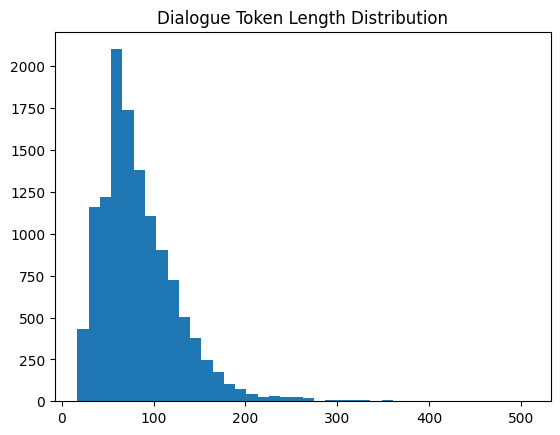

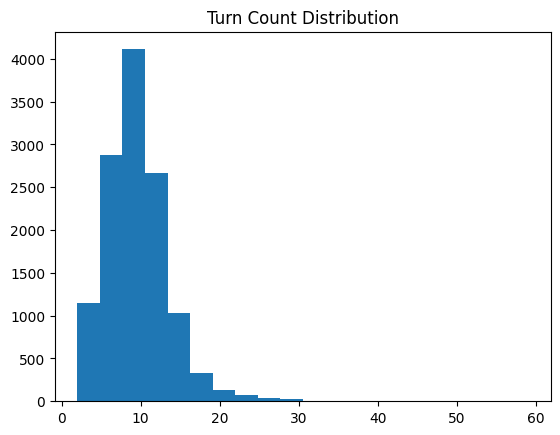

count    12457.000000
mean        16.480694
std          7.015613
min          4.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         75.000000
Name: summary_token_len, dtype: float64
count    12457.000000
mean         0.213563
std          0.076621
min          0.052632
25%          0.163934
50%          0.200000
75%          0.245614
max          0.800000
Name: compression_ratio, dtype: float64


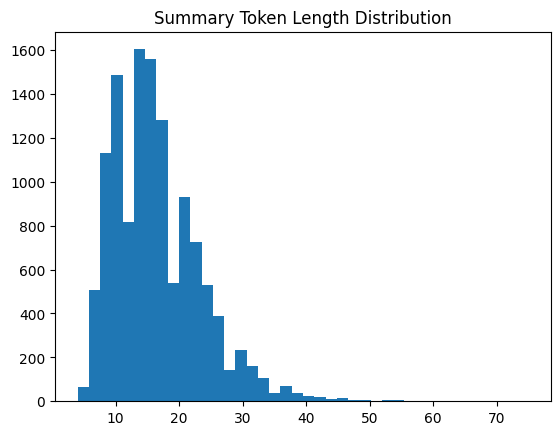

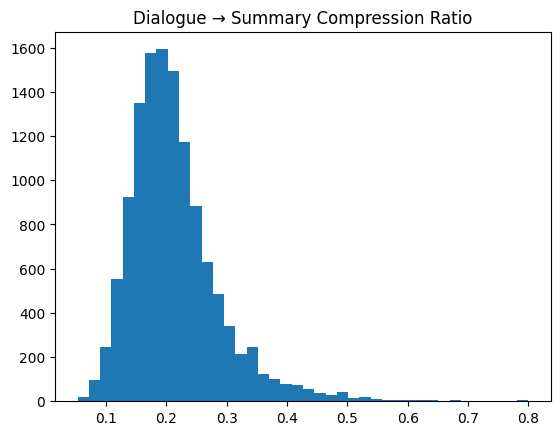


=== Top 40 Frequent Words in dialogue ===
Person               : 118235
1                    : 62397
2                    : 57552
수                    : 9122
네                    : 8046
정말                   : 7808
것                    : 6465
있어                   : 6273
좀                    : 5876
거야                   : 5445
안                    : 5373
아                    : 4485
더                    : 4411
이                    : 4212
잘                    : 4072
그                    : 4053
있어요                  : 3959
어떻게                  : 3917
게                    : 3684
그럼                   : 3570
같아                   : 3448
있는                   : 3209
해                    : 3150
우리                   : 3118
음                    : 2929
너무                   : 2886
한                    : 2861
좋은                   : 2784
여기                   : 2774
응                    : 2730
맞아                   : 2601
오늘                   : 2518
내가                   : 2509
다른                   : 2492
어

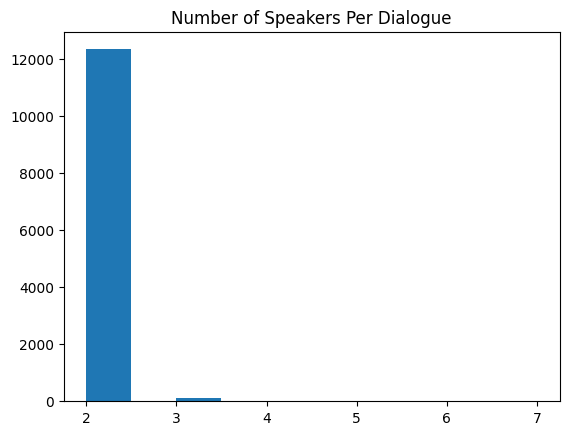

In [5]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

# ================================================
# PATH
# ================================================
PROJECT_ROOT = Path.cwd().parents[1]
RAW_DIR = PROJECT_ROOT / "data" / "raw"

train_df = pd.read_csv(RAW_DIR / "train.csv")
dev_df   = pd.read_csv(RAW_DIR / "dev.csv") if (RAW_DIR / "dev.csv").exists() else None

# ================================================
# Tokenizer (NO JVM)
# ================================================
def tokenize(text):
    return re.findall(r"[A-Za-z]+|[가-힣]+|\d+", str(text))

# ================================================
# Dialogue Length EDA
# ================================================
def dialogue_length_stats(df):
    print("\n=== Dialogue Length Stats ===")

    df["dialogue_token_len"] = df["dialogue"].apply(lambda x: len(str(x).split()))
    df["turn_count"] = df["dialogue"].apply(lambda x: len(re.findall(r"#Person\d+#", str(x))))

    print(df["dialogue_token_len"].describe())
    print(df["turn_count"].describe())

    plt.hist(df["dialogue_token_len"], bins=40)
    plt.title("Dialogue Token Length Distribution")
    plt.show()

    plt.hist(df["turn_count"], bins=20)
    plt.title("Turn Count Distribution")
    plt.show()

# ================================================
# Summary Length & Compression Ratio
# ================================================
def summary_stats(df):
    df["summary_token_len"] = df["summary"].apply(lambda x: len(str(x).split()))
    df["compression_ratio"] = df["summary_token_len"] / df["dialogue_token_len"]

    print(df["summary_token_len"].describe())
    print(df["compression_ratio"].describe())

    plt.hist(df["summary_token_len"], bins=40)
    plt.title("Summary Token Length Distribution")
    plt.show()

    plt.hist(df["compression_ratio"], bins=40)
    plt.title("Dialogue → Summary Compression Ratio")
    plt.show()

# ================================================
# Word Frequency
# ================================================
def frequent_words(df, col="dialogue", topn=40):
    print(f"\n=== Top {topn} Frequent Words in {col} ===")
    all_tokens = []
    for text in df[col]:
        all_tokens += tokenize(str(text))
    counter = Counter(all_tokens)
    for word, cnt in counter.most_common(topn):
        print(f"{word:20} : {cnt}")
    return counter

# ================================================
# Stopword Ratio
# ================================================
stopwords = {
    "이", "그", "저", "제", "것", "수", "등", "더", "또", "그리고", "근데",
    "하지만", "그래서", "그러나", "그러니까",
    "the", "a", "an", "and", "but", "or", "if"
}

def stopword_ratio(df):
    ratios = []
    for text in df["dialogue"]:
        tokens = tokenize(str(text))
        if len(tokens) == 0:
            continue
        sw_cnt = sum(t in stopwords for t in tokens)
        ratios.append(sw_cnt / len(tokens))
    print(pd.Series(ratios).describe())

# ================================================
# Emotion Keywords
# ================================================
emotion_keywords = ["좋아", "기뻐", "행복", "불안", "걱정", "싫어", "짜증", "화나", "슬퍼", "ㅋㅋ", "ㅎㅎ"]

def emotion_keyword_counts(df):
    print("\n=== Emotion Keyword Frequency ===")
    counts = {k: 0 for k in emotion_keywords}
    for text in df["dialogue"]:
        for k in emotion_keywords:
            if k in text:
                counts[k] += 1
    for k, v in counts.items():
        print(f"{k:10} : {v}")

# ================================================
# Speaker Participation
# ================================================
def speaker_stats(df):
    print("\n=== Speaker Participation Stats ===")
    df["speaker_count"] = df["dialogue"].apply(
        lambda x: len(set(re.findall(r"#Person(\d+)#", str(x))))
    )
    print(df["speaker_count"].describe())

    plt.hist(df["speaker_count"], bins=10)
    plt.title("Number of Speakers Per Dialogue")
    plt.show()

# ================================================
# RUN FULL EDA
# ================================================
def run_full_eda(df, name="train"):
    print(f"\n========== FULL EDA: {name} ==========")
    dialogue_length_stats(df)
    summary_stats(df)
    frequent_words(df, col="dialogue")
    frequent_words(df, col="summary")
    stopword_ratio(df)
    emotion_keyword_counts(df)
    speaker_stats(df)

run_full_eda(train_df, "train")
